# Experiments


In [2]:
#%load_ext tensorboard
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
import math
import pickle
import shutil
import scipy.io as sio
import sklearn.datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import LinearSVC

from scipy.stats import iqr



tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# Mount Google Drive
from google.colab import drive, files
import sys
drive.mount('/content/drive', force_remount = True)

sys.path.append('/content/drive/MyDrive/DeepAtlas')
from PCAE import PCAE, Chart, Gating_network

"""
with open('example.txt', 'w') as f:
  f.write('some content')
files.download('example.txt')
"""

Mounted at /content/drive


"\nwith open('example.txt', 'w') as f:\n  f.write('some content')\nfiles.download('example.txt')\n"

## Fit PCAE (function)


In [5]:
 def fit_PCAE(dataset,n_charts,width_charts_e,width_charts_d,width_g_n,N_epochs,passes,starting_learning_rate,PCAE_parameters):
  alpha_load = PCAE_parameters["alpha_load"]
  alpha_importance = PCAE_parameters["alpha_importance"]
  alpha_classification= PCAE_parameters["alpha_classification"]
  alpha_inverse_reconstruction = PCAE_parameters["alpha_inverse_reconstruction"]
  main_loss_type = PCAE_parameters["main_loss_type"]
  load_softmax_like = PCAE_parameters["load_softmax_like"]
  load_softmax_exponent = PCAE_parameters["load_softmax_exponent"]
  softmax_exponent = PCAE_parameters["softmax_exponent"]
  clustering_space = PCAE_parameters["clustering_space"]
  clustering_alg = PCAE_parameters["clustering_alg"]
  average_or_total = PCAE_parameters["average_or_total"]
  split_chart_tolerance = PCAE_parameters["split_chart_tolerance"]
  run_eagerly = PCAE_parameters["run_eagerly"]
  verbose = PCAE_parameters["verbose"]

  npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+dataset+'_data.npz')
  training_data = npzfile["training_data"]
  test_data = npzfile["test_data"]


  if dataset == "mnist":
    training_data = training_data[0:30000]
    test_data = test_data[0:5000]

  # Turn the data into tensors
  test_data =  tf.convert_to_tensor(test_data, dtype = tf.float32)
  training_data =  tf.convert_to_tensor(training_data,dtype = tf.float32)

  # Renormalize data
  std_dataset = tf.cast(tf.math.reduce_euclidean_norm(tf.math.reduce_std(training_data, axis = 0)),tf.float32)
  # tf.print(std_dataset)

  training_data /= std_dataset
  test_data /= std_dataset


  # Define PCAE
  # Create charts
  charts = []
  for i in range(n_charts):
    charts.append(Chart(width_charts_e,[tf.nn.selu]*(len(width_charts_e)-1)+[None],width_charts_d,[tf.nn.selu]*(len(width_charts_d)-1)+[None]))
  
  # Create gating network
  if len(width_g_n) != 0:
    rest_of_the_network = tf.keras.Sequential()
    for w in width_g_n:
      rest_of_the_network.add( tf.keras.layers.Dense(w, activation= "selu"))
  else:
    rest_of_the_network = None 
  gating_network = Gating_network(output_layer = tf.keras.layers.Dense(len(charts), activation= None),rest_of_the_network = rest_of_the_network)


  my_PCAE = PCAE(charts,gating_network, main_loss_type = main_loss_type, \
                load_softmax_like = load_softmax_like, load_softmax_exponent = load_softmax_exponent, \
                softmax_exponent = softmax_exponent , alpha_load = alpha_load, alpha_importance = alpha_importance,\
                alpha_classification= alpha_classification, alpha_inverse_reconstruction=alpha_inverse_reconstruction,\
                 verbose=verbose, run_eagerly = run_eagerly)


  batch_size = 1000
  optimizer = tf.keras.optimizers.Adam(
      beta_1=0.9,
      beta_2=0.999,
      learning_rate=0.001  )
  callback = tf.keras.callbacks.EarlyStopping(monitor='main_reconstruction_loss', min_delta =0.00001, mode ="min", patience=400)


  #tf.debugging.enable_check_numerics()

  history = []
  # Train
  for i in range(N_epochs):
    epoch_history = {}
    for j, epochs in enumerate(passes[i]):
      optimizer.learning_rate = starting_learning_rate *(10**(-j))*(2**(-i))
      my_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)
      epoch_history = update_history(epoch_history,my_PCAE.fit(training_data,epochs=epochs,batch_size=batch_size,callbacks = [callback]).history)
      tf.print(str(i)+" : "+str(j))
    if i!= N_epochs-1:
      # create new chart
      class_split = my_PCAE.create_new_chart(tf.random.shuffle(training_data)[0:1000],split_chart_tolerance,clustering_space = clustering_space, clustering_alg = clustering_alg, average_or_total = average_or_total)
    history.append(epoch_history)

  # measure performance
  [_,_,x_reconstructed_inference]=my_PCAE(test_data,training = False)
  [z_training_mode,softmax_weights,x_reconstructed_training_mode]=my_PCAE(test_data,training = True)
  reconstruction_error = tf.reduce_mean(tf.reduce_sum(tf.math.square(test_data-x_reconstructed_inference),axis=1),0)
  load_loss = my_PCAE.load_loss(softmax_weights)
  importance_loss = my_PCAE.importance_loss(softmax_weights)
  classification_loss = my_PCAE.classification_loss(x_reconstructed_training_mode, softmax_weights,run_eagerly = False)
  inverse_reconstruction_loss = my_PCAE.inverse_reconstruction_loss(z_training_mode,x_reconstructed_training_mode, softmax_weights, run_eagerly = False)
  # history has the shape of a list of length N_epochs, each containing a dictionary whose
  # keys are the name of the losses, and whose values are records of the values of those losses
  # over the epoch
  return reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, classification_loss, my_PCAE, history


def update_history(old_history,new_history):
  for key in new_history.keys():
    if key in old_history.keys():
      old_history[key] = old_history[key] + new_history[key]
    else:
      old_history[key] = new_history[key]
  return old_history
  

In [ ]:
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.1
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

n_charts = 4
width_charts_e = [10,10,10,2]
width_charts_d = [10,10,10,3]
width_g_n = [10,10]
N_epochs = 1
passes = [[20]]

dataset = "torus"


reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts,width_charts_e,width_charts_d,width_g_n,N_epochs,passes,PCAE_parameters)


## Fit PCAE (legacy)

In [ ]:

drive.mount('/content/drive', force_remount = True)
# Download data
dataset = 'torus'

npzfile = np.load('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Datasets/'+dataset+'_data.npz')
training_data = npzfile["training_data"]
test_data = npzfile["test_data"]


# Turn the data into tensors
test_data =  tf.convert_to_tensor(test_data, dtype = tf.float32)
training_data =  tf.convert_to_tensor(training_data,dtype = tf.float32)

# Renormalize data
std_dataset = tf.cast(tf.math.reduce_euclidean_norm(tf.math.reduce_std(training_data, axis = 0)),tf.float32)
# tf.print(std_dataset)

training_data /= std_dataset
test_data /= std_dataset

# Define PCAE
charts = []
rest_of_the_network = tf.keras.Sequential()
rest_of_the_network.add( tf.keras.layers.Dense(10, activation= "selu"))
rest_of_the_network.add( tf.keras.layers.Dense(10, activation= "selu"))
#rest_of_the_network = None
for i in range(5):
  charts.append(Chart([7,7,7,2],[tf.nn.selu,tf.nn.selu, tf.nn.selu, None],[7,7,7,3],[tf.nn.selu,tf.nn.selu, tf.nn.selu, None]))
gating_network = Gating_network(output_layer = tf.keras.layers.Dense(len(charts), activation= None),rest_of_the_network = rest_of_the_network)

alpha_load = 0.1
alpha_importance = 0.0
alpha_classification= 0
alpha_inverse_reconstruction=0
charts_weights_inside_norm = False
load_softmax_like = False
load_softmax_exponent = 4
softmax_exponent = 1.0
clustering_space = "input_space"
clustering_alg = "k_means"
split_chart_tolerance = 0.0001

my_PCAE = PCAE(charts,gating_network, charts_weights_inside_norm = charts_weights_inside_norm, \
               load_softmax_like = load_softmax_like, load_softmax_exponent = load_softmax_exponent, \
               softmax_exponent = softmax_exponent , alpha_load = alpha_load, alpha_importance = alpha_importance,\
               alpha_classification= alpha_classification, alpha_inverse_reconstruction=alpha_inverse_reconstruction)


batch_size = 1000
optimizer = tf.keras.optimizers.Adam(
    beta_1=0.9,
    beta_2=0.999,
    learning_rate = 0.001
)
run_eagerly = False

my_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)


tf.debugging.enable_check_numerics()

N = 1

x_reconstructed_test_saved =[]
x_reconstructed_training_saved=[]
indices_charts_test_saved=[]
indices_charts_training_saved=[]
z_training_saved=[]
z_test_saved=[]
class0_split_saved= np.zeros((N,), dtype=np.object)
class1_split_saved= np.zeros((N,), dtype=np.object)


tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)


callback = tf.keras.callbacks.EarlyStopping(monitor='main_reconstruction_loss', min_delta =0.0001, mode ="min", patience=20)

#my_PCAE.fit(training_data,epochs=50,batch_size=batch_size)
for i in range(N):
  for j, epochs in enumerate([100]):
    optimizer.learning_rate = 1e-04 *(10**(1-j))*(2.5**(-i))
    my_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)
    my_PCAE.fit(training_data,epochs=epochs,batch_size=batch_size, callbacks= [callback])
    tf.print(str(i)+" : "+str(j))
  [z_test,indices_charts_test,x_reconstructed_test]=my_PCAE(test_data,training = False)
  [z_training,indices_charts_training,x_reconstructed_training]=my_PCAE(training_data,training = False)
   # average error
  tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(test_data-x_reconstructed_test),axis=1),0))
  class_split = my_PCAE.create_new_chart(tf.random.shuffle(training_data)[0:1000],split_chart_tolerance,clustering_space = clustering_space, clustering_alg = clustering_alg )
  # Saves the results
  x_reconstructed_test_saved.append(x_reconstructed_test.numpy())
  x_reconstructed_training_saved.append(x_reconstructed_training.numpy())
  indices_charts_test_saved.append(indices_charts_test.numpy())
  indices_charts_training_saved.append(indices_charts_test.numpy())
  z_training_saved.append(z_training.numpy())
  z_test_saved.append(z_test.numpy())
  class0_split_saved[i] = class_split["class0"]
  class1_split_saved[i] = class_split["class1"]
  
  
results = {"test_data": test_data.numpy(),\
        "training_data": training_data.numpy(),\
        "test_reconstructed": np.array(x_reconstructed_test_saved), \
        "training_reconstructed": np.array(x_reconstructed_training_saved), \
        "indices_training": np.array(indices_charts_training_saved), \
        "indices_test": np.array(indices_charts_test_saved), \
        "z_training":np.array(z_training_saved), \
        "z_test":np.array(z_test_saved),\
        "class0": class0_split_saved,\
        "class1": class1_split_saved}
# Downloads the results as .mat files on the local machine, as well as numpy archives on Google Drive
sio.savemat(dataset+"_results_fit_PCAE.mat",results)
files.download(dataset+"_results_fit_PCAE.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Fit_PCAE/'+dataset,**results)


### Show extended charts


In [ ]:
drive.mount('/content/drive', force_remount = True)
num_charts = len(my_PCAE.list_of_charts)

extended_charts = np.zeros((num_charts,), dtype=np.object)

for i in range(num_charts):
  extended_chart = np.zeros((2,), dtype=np.object)
  encoded_points = []
  images = []
  for a in np.linspace(-2,2, num=60):
    for b in np.linspace(-2,2, num=60):
      encoded_points.append(np.array([a,b]))
      images.append(my_PCAE.list_of_charts[i].decode(tf.convert_to_tensor([[a,b]])).numpy()[0,:])
  extended_chart[0] = np.array(encoded_points)
  extended_chart[1] = np.array(images)
  extended_charts[i] = extended_chart
  print("Chart "+str(i)+" done")

extended_charts_saved = {"extended_charts": extended_charts}

sio.savemat(dataset+"_extended_charts.mat",extended_charts_saved)
files.download(dataset+"_extended_charts.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Various_visualisations/'+dataset+"_extended_charts",**extended_charts_saved)




## Hyperparameter testing

### Main loss


In [ ]:
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

#datasets = ["torus_sphere","uniform_sphere_dim_40"]
datasets = ["mnist","yale_faces"]
#datasets = ["uniform_sphere_dim_40"]
name_exp = "main_loss"


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-3),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[1000,3000,5000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}

main_loss_types = ["inside","outside","exp"]




for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","w")

  f.write("type of main loss      reconstruction      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  for main_loss_type in main_loss_types:
      PCAE_parameters["main_loss_type"] = main_loss_type
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

      f.write(main_loss_type+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
  f.close()
  files.download("hyperparameter_"+name_exp+"_"+dataset+".txt")



Epoch 1/500


KeyboardInterrupt: ignored

In [ ]:
npzfile = np.load('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Datasets/uniform_sphere_dim_40_data.npz')
training_data = npzfile["training_data"]
test_data = npzfile["test_data"]
[z_test,indices_charts_test,x_reconstructed_test]=my_PCAE(test_data,training = False)
tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(test_data-x_reconstructed_test),axis=1),0))
my_PCAE.fit(training_data,epochs = 3,batch_size= 1000)



0.24265191
Epoch 1/3
1/1 [==============================] - 0s 5ms/step - main_reconstruction_loss: 0.0940 - number_of_charts: 2.0000
Epoch 2/3
1/1 [==============================] - 0s 7ms/step - main_reconstruction_loss: 0.0937 - number_of_charts: 2.0000
Epoch 3/3
1/1 [==============================] - 0s 7ms/step - main_reconstruction_loss: 0.0936 - number_of_charts: 2.0000


In [ ]:
[z_test,indices_charts_test,x_reconstructed_test]=my_PCAE(test_data,training = False)
tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(test_data-x_reconstructed_test),axis=1),0))


0.242253557


### Load and importance losses

In [ ]:
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

#datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]
datasets = ["mnist","yale_faces"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}


load_alphas = [0.0,0.01,0.1]
importance_alphas = [0.0,0.01,0.1]

name_exp = "load_or_importance"

%%capture

for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("(alpha_load,alpha_importance)  reconstruction      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for alpha_load in load_alphas:
    for alpha_importance in importance_alphas:
      PCAE_parameters["alpha_load"] = alpha_load
      PCAE_parameters["alpha_importance"] = alpha_importance
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write("("+str(alpha_load)+","+str(alpha_importance)+")       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
      files.download("hyperparameter_"+name_exp+"_"+dataset+".txt")
      f.close()





###Load like softmax


In [ ]:
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[200,300,400]],"yale_faces":[[1000,1000]],"mnist":[[200,400]],"uniform_sphere_dim_40":[[1000,1000]]}


PCAE_parameters["alpha_load"] = 0.01
PCAE_parameters["load_softmax_like"] = True
load_softmax_exponents = [1,2,4,8]


name_exp = "softmax_like_load"
f = open("hyperparameter_"+name_exp+".txt","w")



f.write("softmax load exponent  reconstruction      load      importance  ")
f.write("\n")
for dataset in datasets:
  f.write(dataset+":\n")
  for load_softmax_exponent in load_softmax_exponents:
      PCAE_parameters["load_softmax_exponent"] = load_softmax_exponent
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

      f.write(str(load_softmax_exponent)+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
  f.write("--------------------\n")

f.close()
files.download("hyperparameter_"+name_exp+".txt")
shutil.copyfile("hyperparameter_"+name_exp+".txt",'/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Hyperparameter_selection/'+name_exp+'.txt')



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 45ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7323
Epoch 503/1000
1/1 [==============================] - 0s 38ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7323
Epoch 504/1000
1/1 [==============================] - 0s 36ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7323
Epoch 505/1000
1/1 [==============================] - 0s 36ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7323
Epoch 506/1000
1/1 [==============================] - 0s 42ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7323
Epoch 507/1000
1/1 [==============================] - 0s 37ms/step - main_reconstruction_loss: 0.0358 - number_of_charts: 10.0000 - load_loss: 1.7322
Epoch 508/1000
1/1 [=================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Hyperparameter_selection/softmax_like_load.txt'

### Classification


In [ ]:
%%capture
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]
datasets = [ "mnist"]



n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}


classification_alphas = [0.0,0.01,0.1,0.25]


name_exp = "classification"

for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("alpha_classification      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for alpha_classification in classification_alphas:
      PCAE_parameters["alpha_classification"] = alpha_classification
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write(str(alpha_classification)+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
      f.close()


### Inverse reconstruction


In [ ]:

%%capture
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}



inverse_reconstruction_alphas = [0.0,0.01,0.1,0.25]


name_exp = "inverse_reconstruction"

for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("alpha_inverse_reconstruction reconstruction      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for alpha_inverse_reconstruction in inverse_reconstruction_alphas:
      PCAE_parameters["alpha_inverse_reconstruction"] = alpha_inverse_reconstruction
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write(str(alpha_inverse_reconstruction)+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
      f.close()
      files.download("hyperparameter_"+name_exp+"_"+dataset+".txt")



### Softmax exponent


In [ ]:
%%capture
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]
datasets = ["yale_faces"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}



softmax_exponents = [1,2,4,10]

softmax_exponents = [1,2,4,10]

name_exp = "softmax_exponent"
 
for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("softmax_exponent      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for softmax_exponent in softmax_exponents:
      PCAE_parameters["softmax_exponent"] = softmax_exponent
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write(str(softmax_exponent)+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
      f.close()


### Various numbers of charts

In [ ]:
%%capture
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}




numbers_of_charts = {"torus_sphere":[1,3,6,12],"yale_faces":[1,5,10,20],"mnist":[1,5,10,20],"uniform_sphere_dim_40":[1,2,4,8]}


name_exp = "various_fixed_num_charts"

for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("number_charts      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for n_charts in numbers_of_charts[dataset]:
      
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts,width_charts_e[dataset], \
      width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
      
      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write(str(n_charts)+"       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
      f.close()
      files.download("hyperparameter_"+name_exp+"_"+dataset+".txt")
     

### Increasing number of charts

In [ ]:

def transform_history(history):
  N=len(history)
  new_history = {}
  for i in range(N):
    new_history[str(i+1)] = np.array(history[i]["main_reconstruction_loss"])

  return new_history



In [ ]:

%%capture
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.01
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["torus_sphere","uniform_sphere_dim_40","mnist","yale_faces"]
datasets = ["mnist"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}


N_epochs = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":4}
passes = {"torus_sphere":[[1000,2000,3000]]*6,"yale_faces":[[800,800,800]]*10,"mnist":[[100,400,800]]*10,"uniform_sphere_dim_40":[[1000,2000,4000]]*4}


clustering_algs = ["k_means","agglom_clustering"]
clustering_algs = ["agglom_clustering"]
clustering_spaces = ["input_space","gating_network_encoding_space","encoding_space"]
average_or_total = ["average","total"]

name_exp = "dynamic_chart_number"



for dataset in datasets:
  for clustering_alg in clustering_algs:
    f = open("hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg+".txt","a")
    f.write("(space,alg,option)          reconstruction      load      importance  ")
    f.write("\n")
    f.write(dataset+":\n")
    f.close()
    for clustering_space in clustering_spaces:
      for option in average_or_total:
      
        PCAE_parameters["clustering_space"] = clustering_space
        PCAE_parameters["clustering_alg"] = clustering_alg
        PCAE_parameters["average_or_total"] = option 

        reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
        classification_loss, _, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
        width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

        reconstruction_history = transform_history(history)
        sio.savemat("hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg+".mat",reconstruction_history)
        files.download("hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg+".mat")
        np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Hyperparameter_selection/'+"hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg,**reconstruction_history )
        f = open("hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg+".txt","a")
        f.write("("+clustering_space+","+clustering_alg+","+option+")       ["+str(reconstruction_error.numpy())+" , "+str(load_loss.numpy())+" , "+str(importance_loss.numpy())+"]   \n")
        f.close()
        files.download("hyperparameter_"+name_exp+"_"+dataset+"_"+clustering_alg+".txt")





In [ ]:
print(type(history))
print(history)
print(transform_history(history))

<class 'list'>
[{'main_reconstruction_loss': [0.805069088935852, 0.6305681467056274, 0.48808979988098145], 'number_of_charts': [6, 6, 6], 'load_loss': [0.5706038475036621, 0.46024271845817566, 0.47027817368507385]}, {'main_reconstruction_loss': [0.44670185446739197, 0.4185512065887451, 0.3657747507095337], 'number_of_charts': [7, 7, 7], 'load_loss': [0.30141064524650574, 0.297212690114975, 0.26914820075035095]}]
{'1': array([0.80506909, 0.63056815, 0.4880898 ]), '2': array([0.44670185, 0.41855121, 0.36577475])}


###Optimally distributed charts (MNIST and Yale Face)


In [ ]:

PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.01
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["yale_faces"]


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2}
width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]]}

name_exp = "optimally_distributed_charts"



for dataset in datasets:
    f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
    f.write("reconstruction  ")
    f.write("\n")
    f.write(dataset+":\n")
    f.close()
    total_average_error = 0
    total_number_samples = 0
    for i in range(10):
        npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+dataset+'_class'+str(i)+'only_data.npz')
        n_test_samples = len(npzfile["test_data"])
        total_number_samples += n_test_samples

        reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
        classification_loss, _, history= fit_PCAE(dataset+'_class'+str(i)+'only',n_charts[dataset],width_charts_e[dataset], \
        width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
        
        f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
        f.write("local error "+str(i)+" = "+str(reconstruction_error)+"\n")
        f.close()
        
        total_average_error += reconstruction_error.numpy()*n_test_samples
    total_average_error = total_average_error/total_number_samples
    f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
    f.write("average error = "+str(total_average_error)+"\n")
    f.close()
    files.download("hyperparameter_"+name_exp+"_"+dataset+".txt")





### Optimal simple NN

In [ ]:


PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "outside"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["swiss_roll","higgs","torus_sphere","uniform_sphere_dim_40","yale_faces","mnist"]
datasets = ["mnist"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2,"swiss_roll":6,"higgs":10}
#width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
#width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
#width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2),"swiss_roll":10**(-3),"higgs":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]],"swiss_roll":[[2000,4000,8000]],"higgs":[[1000,2000,4000]]}


width_g_n = {"torus_sphere":[],"yale_faces":[],"mnist":[],"uniform_sphere_dim_40":[],"higgs":[],"swiss_roll":[]}
n_charts = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}

width_charts_e = {}
width_charts_e["torus_sphere"]={"small":[7,7,7,2],"medium":[21,21,21,2],"large":[42,42,42,2]}
width_charts_e["yale_faces"]={"small":[500,250,100,50],"medium":[1500,750,300,50],"large":[2500,2500,1000,50]}
width_charts_e["mnist"]={"small":[250,100,50],"medium":[750,300,50],"large":[2500,1000,50]}
width_charts_e["uniform_sphere_dim_40"]={"small":[40,40],"medium":[60,40],"large":[80,40]}
width_charts_e["swiss_roll"]={"small":[7,7,7,2],"medium":[21,21,21,2],"large":[42,42,42,2]}
width_charts_e["higgs"]={"small":[25,25,10],"medium":[100,100,10],"large":[250,250,10]}


width_charts_d = {}
width_charts_d["torus_sphere"]={"small":[7,7,7,3],"medium":[21,21,21,3],"large":[42,42,42,3]}
width_charts_d["yale_faces"]={"small":[100,250,500,2500],"medium":[300,750,1500,2500],"large":[1000,2500,2500,2500]}
width_charts_d["mnist"]={"small":[100,200,784],"medium":[300,600,784],"large":[1000,2000,784]}
width_charts_d["uniform_sphere_dim_40"]={"small":[40,80],"medium":[60,80],"large":[80,80]}
width_charts_d["swiss_roll"]={"small":[7,7,7,3],"medium":[21,21,21,3],"large":[42,42,42,3]}
width_charts_d["higgs"]={"small":[25,25,21],"medium":[100,100,21],"large":[250,250,21]}


sizes = ["small", "medium", "large"]
sizes = ["large"]
name_exp = "optimal_NN"
 
for dataset in datasets:
  f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
  f.write("size      load      importance  ")
  f.write("\n")
  f.write(dataset+":\n")
  f.close()
  for size in sizes:
      width_charts_encoder = width_charts_e[dataset][size]
      width_charts_decoder = width_charts_d[dataset][size]
      reconstruction_error, load_loss, importance_loss, inverse_reconstruction_loss, \
      classification_loss, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_encoder, \
      width_charts_decoder,width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)

      f = open("hyperparameter_"+name_exp+"_"+dataset+".txt","a")
      f.write(size+"       "+str(reconstruction_error.numpy())+"   \n")
      f.close()


## Classification


### Classify with classical autoencoder

In [ ]:
%%capture
# Parameters 
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "outside"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["swiss_roll","higgs","torus_sphere","uniform_sphere_dim_40","yale_faces","mnist"]

datasets = ["yale_faces"]

n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2,"swiss_roll":6,"higgs":10}
#width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
#width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
#width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2),"swiss_roll":10**(-3),"higgs":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]],"swiss_roll":[[2000,4000,8000]],"higgs":[[1000,2000,4000]]}


width_g_n = {"torus_sphere":[],"yale_faces":[],"mnist":[],"uniform_sphere_dim_40":[],"higgs":[],"swiss_roll":[]}
n_charts = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}

width_charts_e = {}
width_charts_e["torus_sphere"]=[42,42,42,2]
width_charts_e["yale_faces"]=[2500,2500,1000,50]
width_charts_e["mnist"]= [750,300,50] 
width_charts_e["uniform_sphere_dim_40"]=[40,40]
width_charts_e["swiss_roll"]=[21,21,21,2]
width_charts_e["higgs"]=[250,250,10]


width_charts_d = {}
width_charts_d["torus_sphere"]= [42,42,42,3]
width_charts_d["yale_faces"]= [1000,2500,2500,2500]
width_charts_d["mnist"]= [300,600,784] 
width_charts_d["uniform_sphere_dim_40"]= [40,80]
width_charts_d["swiss_roll"]= [21,21,21,3]
width_charts_d["higgs"]=[250,250,21]


k= {"torus_sphere":5,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":3,"swiss_roll":4,"higgs":2}

f = open("Classifying_classical_autoencoder.txt","a")
f.write("reconstruction     precision  ")
f.write("\n")
f.close()
for dataset in datasets:
  f = open("Classifying_classical_autoencoder.txt","a")
  f.write(dataset+":\n")

  # Train autoencoder
  reconstruction_error, _, _, _, \
  _, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
  width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
  
  # Load data
  npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+dataset+'_data.npz')
  training_data = npzfile["training_data"]
  training_labels = npzfile["training_labels"]
  test_data = npzfile["test_data"]
  test_labels = npzfile["test_labels"]

  # Encode
  [z_training, _, _] = my_PCAE(training_data,training = False)
  [z_test, _, _] = my_PCAE(test_data,training = False)
  
  # Apply k-nearest neighbours
  clf = sklearn.neighbors.KNeighborsClassifier(k[dataset], weights="uniform")
  clf.fit(z_training, training_labels)
  predicted_labels = clf.predict(z_test)
  # Compute precision
  precision =np.sum([1 if predicted_labels[i]== correct_label else 0 for i, correct_label in enumerate(test_labels)])/len(predicted_labels)
  
  f.write(str(reconstruction_error.numpy())+" , "+str(precision)+"]   \n")
  f.close()

files.download("Classifying_classical_autoencoder.txt")


### Deep Atlas, one per chart


In [ ]:
%%capture
# Parameters 
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.01
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "outside"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["swiss_roll","torus_sphere","uniform_sphere_dim_40","mnist","yale_faces","higgs"]
datasets = ["higgs","yale_faces","mnist"]


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2,"swiss_roll":6,"higgs":10}
width_charts_e = {"swiss_roll":[7,7,7,2],"higgs":[25,25,10],"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"swiss_roll":[7,7,7,3],"higgs":[25,25,21],"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"swiss_roll":[10,10],"higgs":[25,25],"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2),"swiss_roll":10**(-3),"higgs":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]],"swiss_roll":[[2000,4000,8000]],"higgs":[[2000,4000,6000]]}


k= {"torus_sphere":5,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":3,"swiss_roll":4,"higgs":2}

f = open("Classifying_Deep_Atlas_local.txt","a")
f.write("reconstruction     precision  ")
f.write("\n")
f.close()
for dataset in datasets:
  f = open("Classifying_Deep_Atlas_local.txt","a")
  f.write(dataset+":\n")

  # Train autoencoder
  reconstruction_error, _, _, _, \
  _, my_PCAE, history= fit_PCAE(dataset,n_charts[dataset],width_charts_e[dataset], \
  width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
  
  # Load data
  npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+dataset+'_data.npz')
  training_data = npzfile["training_data"]
  training_labels = npzfile["training_labels"]
  test_data = npzfile["test_data"]
  test_labels = npzfile["test_labels"]

  # Encode
  [z_training, indices_training, _] = my_PCAE(training_data,training = False)
  [z_test, indices_test, _] = my_PCAE(test_data,training = False)
  z_training = z_training.numpy()
  z_test = z_test.numpy()


  # Apply k-nearest neighbours on each chart
  correct_predictions = 0
  for chart_index in range(len(my_PCAE.list_of_charts)):
    if len([i for i in indices_test if i==chart_index])!= 0:
      z_training_local = [z for index, z in enumerate(z_training) if indices_training[index]==chart_index]
      training_labels_local = [label for index, label in enumerate(training_labels) if indices_training[index] == chart_index]
      z_test_local = [z for index, z in enumerate(z_test) if indices_test[index]==chart_index]
      test_labels_local = [label for index, label in enumerate(test_labels) if indices_test[index] == chart_index]
      
      z_training_local = np.array(z_training_local)
      z_test_local = np.array(z_test_local)
      training_labels_local = np.array(training_labels_local)
      test_labels_local = np.array(test_labels_local)


      clf = sklearn.neighbors.KNeighborsClassifier(min(k[dataset],len(z_test_local),len(z_training_local)), weights="uniform")

      clf.fit(z_training_local,training_labels_local)
      predicted_labels = clf.predict(z_test_local)
      correct_predictions = correct_predictions + np.sum([1 if predicted_labels[i]== correct_label else 0 for i, correct_label in enumerate(test_labels_local)])
  # Compute precision
  precision =correct_predictions/len(indices_test)
  
  
  f.write(str(reconstruction_error.numpy())+" , "+str(precision)+"]   \n")
  f.close()

files.download("Classifying_Deep_Atlas_local.txt",)





In [ ]:
print(min(1,2,3))


1


## Unsupervised anomaly detection


###With classical autoencoder

In [8]:
# Parameters 
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "outside"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["higgs1","higgs2","torus_sphere","swiss_roll","uniform_sphere_dim_40","mnist","yale_faces"]
datasets =["torus_sphere"]


n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2,"swiss_roll":6,"higgs":10}
#width_charts_e = {"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
#width_charts_d = {"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
#width_g_n = {"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2),"swiss_roll":10**(-3),"higgs":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]],"swiss_roll":[[2000,4000,8000]],"higgs":[[1000,2000,4000]]}


width_g_n = {"torus_sphere":[],"yale_faces":[],"mnist":[],"uniform_sphere_dim_40":[],"higgs":[],"swiss_roll":[]}
n_charts = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}

width_charts_e = {}
width_charts_e["torus_sphere"]=[42,42,42,2]
width_charts_e["yale_faces"]=[2500,2500,1000,50]
width_charts_e["mnist"]= [750,300,50] 
width_charts_e["uniform_sphere_dim_40"]=[40,40]
width_charts_e["swiss_roll"]=[21,21,21,2]
width_charts_e["higgs"]=[250,250,10]


width_charts_d = {}
width_charts_d["torus_sphere"]= [42,42,42,3]
width_charts_d["yale_faces"]= [1000,2500,2500,2500]
width_charts_d["mnist"]= [300,600,784] 
width_charts_d["uniform_sphere_dim_40"]= [40,80]
width_charts_d["swiss_roll"]= [21,21,21,3]
width_charts_d["higgs"]=[250,250,21]



anomaly_percentage = {"torus_sphere":0.05,"swiss_roll":0.05,"uniform_sphere_dim_40":0.05,"mnist":0.05,"yale_faces":0.1,"higgs":0.05}


f = open("UAD_classical_autoencoder.txt","a")

f.write("True negatives rate          True positives rate")
f.write("\n")
f.close()
for dataset in datasets:
  f = open("UAD_classical_autoencoder.txt","a")
  f.write(dataset+":\n")

  true_dataset = dataset
  if dataset in ["higgs1","higgs2"]:
    dataset = "higgs"


  # Train autoencoder
  reconstruction_error, _, _, _, \
  _, my_PCAE, history= fit_PCAE(true_dataset+"_anomaly",n_charts[dataset],width_charts_e[dataset], \
  width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
  
  # Load data
  npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+true_dataset+'_anomaly_data.npz')
  # Labels are simply "1 = anomaly/0 = not anomaly"
  training_data = npzfile["training_data"]
  training_labels = npzfile["training_labels"]

  # Reconstruct
  [_, _, x_reconstructed] = my_PCAE(training_data,training = False)
  
  # Compute reconstruction errors
  reconstruction_errors = tf.reduce_sum(tf.math.square(training_data-x_reconstructed),axis=1).numpy()
  # compute threshold
  threshold = np.quantile(reconstruction_errors,1-anomaly_percentage[dataset])
  # Classify
  predicted_labels = [1 if error>threshold else 0 for error in reconstruction_errors ]
  total_positive = np.sum([1 if label == 1 else 0 for label in training_labels ])
  total_negative = np.sum([1 if label == 0 else 0 for label in training_labels ])
  true_positive_rate =np.sum([1 if (predicted_labels[i]== correct_label and predicted_labels[i]==1) else 0 for i, correct_label in enumerate(training_labels)])/total_positive
  true_negative_rate =np.sum([1 if (predicted_labels[i]== correct_label and predicted_labels[i]==0) else 0 for i, correct_label in enumerate(training_labels)])/total_negative
  
  f = open("UAD_classical_autoencoder.txt","a")
  f.write(str(true_negative_rate)+" , "+str(true_positive_rate)+"   \n")
  f.close()
  
files.download("UAD_classical_autoencoder.txt")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4/4 [==============================] - 0s 5ms/step - main_reconstruction_loss: 0.0534 - number_of_charts: 1.0000
Epoch 858/2000
4/4 [==============================] - 0s 4ms/step - main_reconstruction_loss: 0.0519 - number_of_charts: 1.0000
Epoch 859/2000
4/4 [==============================] - 0s 7ms/step - main_reconstruction_loss: 0.0525 - number_of_charts: 1.0000
Epoch 860/2000
4/4 [==============================] - 0s 3ms/step - main_reconstruction_loss: 0.0516 - number_of_charts: 1.0000
Epoch 861/2000
4/4 [==============================] - 0s 4ms/step - main_reconstruction_loss: 0.0527 - number_of_charts: 1.0000
Epoch 862/2000
4/4 [==============================] - 0s 5ms/step - main_reconstruction_loss: 0.0536 - number_of_charts: 1.0000
Epoch 863/2000
4/4 [==============================] - 0s 7ms/step - main_reconstruction_loss: 0.0533 - number_of_charts: 1.0000
Epoch 864/2000
4/4 [=====================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###With Deep Atlas


In [11]:

# Parameters 
PCAE_parameters = {}
PCAE_parameters["alpha_load"] = 0.0
PCAE_parameters["alpha_importance"] = 0.0
PCAE_parameters["alpha_classification"] = 0.0
PCAE_parameters["alpha_inverse_reconstruction"] = 0.0
PCAE_parameters["main_loss_type"] = "exp"
PCAE_parameters["load_softmax_like"] = False
PCAE_parameters["load_softmax_exponent"] = 4
PCAE_parameters["softmax_exponent"] = 1.0
PCAE_parameters["clustering_space"] = "input_space"
PCAE_parameters["clustering_alg"] = "k_means"
PCAE_parameters["average_or_total"] = "average"
PCAE_parameters["split_chart_tolerance"] = 0.001
PCAE_parameters["run_eagerly"] = False
PCAE_parameters["verbose"] = False

datasets = ["swiss_roll","torus_sphere","uniform_sphere_dim_40","mnist","yale_faces","higgs1"]



n_charts = {"torus_sphere":6,"yale_faces":10,"mnist":10,"uniform_sphere_dim_40":2,"swiss_roll":6,"higgs":10}
width_charts_e = {"swiss_roll":[7,7,7,2],"higgs":[25,25,10],"torus_sphere":[7,7,7,2],"yale_faces":[500,250,100,50],"mnist":[250,100,50],"uniform_sphere_dim_40":[40,40]}
width_charts_d = {"swiss_roll":[7,7,7,3],"higgs":[25,25,21],"torus_sphere":[7,7,7,3],"yale_faces":[100,250,500,2500],"mnist":[100,200,784],"uniform_sphere_dim_40":[40,80]}
width_g_n = {"swiss_roll":[10,10],"higgs":[25,25],"torus_sphere":[10,10],"yale_faces":[250,50],"mnist":[250,50],"uniform_sphere_dim_40":[]}
starting_learning_rate = {"torus_sphere":10**(-3),"yale_faces":10**(-4),"mnist":10**(-3),"uniform_sphere_dim_40":10**(-2),"swiss_roll":10**(-3),"higgs":10**(-3)}
N_epochs = {"torus_sphere":1,"yale_faces":1,"mnist":1,"uniform_sphere_dim_40":1,"swiss_roll":1,"higgs":1}
passes = {"torus_sphere":[[2000,4000,6000]],"yale_faces":[[4000,4000,4000]],"mnist":[[500,2000,4000]],"uniform_sphere_dim_40":[[2000,4000,8000]],"swiss_roll":[[2000,4000,8000]],"higgs":[[2000,4000,6000]]}



anomaly_percentage = {"torus_sphere":0.05,"swiss_roll":0.05,"uniform_sphere_dim_40":0.05,"mnist":0.05,"yale_faces":0.1,"higgs":0.05}


f = open("UAD_Deep_Atlas.txt","a")

f.write("True negatives rate          True positives rate")
f.write("\n")
f.close()
for dataset in datasets:
  f = open("UAD_Deep_Atlas.txt","a")
  f.write(dataset+":\n")

  true_dataset = dataset
  if dataset in ["higgs1","higgs2"]:
    dataset = "higgs"


  # Train autoencoder
  reconstruction_error, _, _, _, \
  _, my_PCAE2, history= fit_PCAE(true_dataset+"_anomaly",n_charts[dataset],width_charts_e[dataset], \
  width_charts_d[dataset],width_g_n[dataset],N_epochs[dataset],passes[dataset],starting_learning_rate[dataset],PCAE_parameters)
  
  # Load data
  npzfile = np.load('/content/drive/MyDrive/DeepAtlas/Datasets/'+true_dataset+'_anomaly_data.npz')
  # Labels are simply "1 = anomaly/0 = not anomaly"
  training_data = npzfile["training_data"]
  training_labels = npzfile["training_labels"]

  # Reconstruct
  [_, _, x_reconstructed2] = my_PCAE2(training_data,training = False)
  
  # Compute reconstruction errors
  reconstruction_errors2 = tf.reduce_sum(tf.math.square(training_data-x_reconstructed2),axis=1).numpy()
  # compute threshold
  threshold = np.quantile(reconstruction_errors2,1-anomaly_percentage[dataset])
  # Classify
  predicted_labels2 = [1 if error>threshold else 0 for error in reconstruction_errors2 ]
  total_positive = np.sum([1 if label == 1 else 0 for label in training_labels ])
  total_negative = np.sum([1 if label == 0 else 0 for label in training_labels ])
  true_positive_rate =np.sum([1 if (predicted_labels2[i]== correct_label and predicted_labels2[i]==1) else 0 for i, correct_label in enumerate(training_labels)])/total_positive
  true_negative_rate =np.sum([1 if (predicted_labels2[i]== correct_label and predicted_labels2[i]==0) else 0 for i, correct_label in enumerate(training_labels)])/total_negative
  
  f = open("UAD_Deep_Atlas.txt","a")
  f.write(str(true_negative_rate)+" , "+str(true_positive_rate)+"   \n")
  f.close()
  print("finish")
  
files.download("UAD_Deep_Atlas.txt")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4/4 [==============================] - 0s 5ms/step - main_reconstruction_loss: 0.0714 - number_of_charts: 2.0000
Epoch 697/8000
4/4 [==============================] - 0s 4ms/step - main_reconstruction_loss: 0.0715 - number_of_charts: 2.0000
Epoch 698/8000
4/4 [==============================] - 0s 8ms/step - main_reconstruction_loss: 0.0714 - number_of_charts: 2.0000
Epoch 699/8000
4/4 [==============================] - 0s 5ms/step - main_reconstruction_loss: 0.0716 - number_of_charts: 2.0000
Epoch 700/8000
4/4 [==============================] - 0s 9ms/step - main_reconstruction_loss: 0.0715 - number_of_charts: 2.0000
Epoch 701/8000
4/4 [==============================] - 0s 4ms/step - main_reconstruction_loss: 0.0715 - number_of_charts: 2.0000
Epoch 702/8000
4/4 [==============================] - 0s 4ms/step - main_reconstruction_loss: 0.0715 - number_of_charts: 2.0000
Epoch 703/8000
4/4 [=====================

KeyboardInterrupt: ignored

In [9]:

false_predictions2 = [0 if predicted_labels2[i]== correct_label  else 1 for i, correct_label in enumerate(training_labels)]
false_predictions1 = [0 if predicted_labels[i]== correct_label  else 1 for i, correct_label in enumerate(training_labels)]


predictions = {"training_data":training_data,"predictions_classical":false_predictions1,"predictions_deep_atlas":false_predictions2}
# Downloads the results as .mat files on the local machine, as well as numpy archives on Google Drive
sio.savemat("predictions.mat",predictions)


## Classical methods



Automatically created module for IPython interactive environment


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


ISO: 7.2 sec
MDS: 44 sec


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral Embedding: 1.5 sec
t-SNE: 26 sec


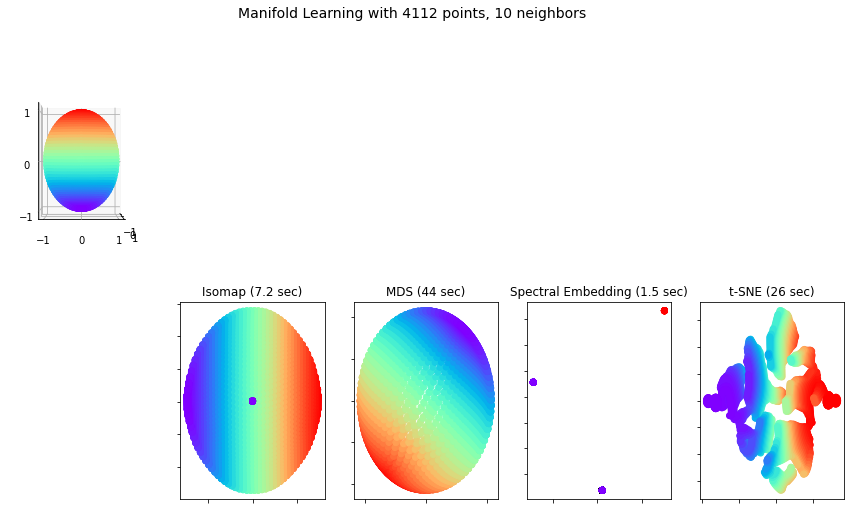

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Author: Jaques Grobler <jaques.grobler@inria.fr> (+ Charles Arnal)
# License: BSD 3 clause

print(__doc__)

from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Next line to silence pyflakes.
Axes3D

# Download data
#drive.mount('/content/drive', force_remount = True)

dataset = 'grid_sphere'

npzfile = np.load('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Datasets/'+dataset+'_data.npz')
data = npzfile["training_data"]
# not always relevant
colors = data[:,2]/np.amax(np.abs(data[:,2]))


# Variables for manifold learning.
n_neighbors = 10
# TODO check if useful
n_samples = data.shape[0]


# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_samples, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=colors, cmap=plt.cm.rainbow)
ax.view_init(0, -0)


results = {"data": data}

"""
# Perform Locally Linear Embedding Manifold learning
methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    images = manifold.LocallyLinearEmbedding(n_neighbors, 2, method=method).fit_transform(data).T
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    results[method+"_LLE"] = images.T
"""

# Perform Isomap Manifold learning.
t0 = time()
images = manifold.Isomap(n_neighbors, n_components=2)\
    .fit_transform(data).T
   
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ('Isomap', t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["Isomap"] = images.T


# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1)
images = mds.fit_transform(data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["MDS"] = images.T

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2,
                                n_neighbors=n_neighbors)
images = se.fit_transform(data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["Spectral_Embedding"] = images.T

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
images = tsne.fit_transform(data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["tSNE"] = images.T

plt.show()

# Downloads the results as .mat files on the local machine, as well as numpy archives on Google Drive
sio.savemat(dataset+"_results_classical_methods.mat",results)
files.download(dataset+"_results_classical_methods.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Classical_methods/'+dataset,**results)

